# 基于XGboost算法构建IS复发预测模型

### 导入模块

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import scipy.stats as st

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,SVR
#from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy.stats import randint as sp_randint
import scipy.stats as stats
from xgboost.sklearn import XGBClassifier

### 读取数据集

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("----------------------------start------------------------")
print(" ")
# training set(1499 data)
dataset_url = '缺血性脑卒中数据表.xlsx'
data = pd.read_excel(dataset_url)
print(data.head(5))
print(" ")
print("-----------------------------------------------------------")
print(" ")
# test set (100 data without R)
dataset_url = '缺血性脑卒中数据表test.xlsx'
testdata = pd.read_excel(dataset_url)
print(testdata.head(5))

----------------------------start------------------------
 
   peptic ulcer  high pressure  Low pressure  suger  Uric acid  Triglycerides  \
0             0            156            69    8.8      351.0           1.58   
1             0            128            64    4.9      351.0           1.58   
2             0            155            95    6.8      351.0           1.58   
3             0            101            70    9.2      351.0           1.58   
4             0            152            90    5.9      351.0           1.58   

   cholesterol   HDL   LDL  Amino acid  Reactive protein  Serum protein  \
0         4.68  1.31  3.07       10.38              9.91           40.3   
1         4.68  1.31  3.07       10.38              9.91           37.6   
2         4.68  1.31  3.07       19.70             24.66           36.3   
3         4.68  1.31  3.07       10.38              9.91           40.3   
4         4.68  1.31  3.07       10.38              9.91           40.3   

  

##  数据预处理
### 读取特征列

In [3]:
# get data's features and labels
X = data.drop('threeMonRecurResult',axis = 1)
y = data.threeMonRecurResult

### 样本划分

In [4]:
# divide into training set and test set randomly
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=13)
# this is the test set (100 data without Ranking)
X_final_test = testdata.drop('threeMonRecurResult',axis = 1)
y_final_test = testdata.threeMonRecurResult
print("训练集：")
print("The shape of X_train:",X_train.shape)
print("The shape of X_test:",X_test.shape)
print("The shape of y_train:",y_train.shape)
print("The shape of y_test:",y_test.shape)
print("测试集：")
print("The shape of X_final_test:",X_final_test.shape)
print("The shape of y_final_test:",y_final_test.shape)

训练集：
The shape of X_train: (1301, 17)
The shape of X_test: (434, 17)
The shape of y_train: (1301,)
The shape of y_test: (434,)
测试集：
The shape of X_final_test: (21, 17)
The shape of y_final_test: (21,)


#### 求得训练集X的均值，方差，最大值，最小值,这些训练集X固有的属性；在fit的基础上，进行标准化

In [5]:
# data standardization(similar to mean normalization)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_final_test = sc.fit_transform(X_final_test)

### 模型构建及训练

In [6]:
# Xgboost训练过程
model = XGBClassifier(learning_rate =0.001, n_estimators=100, max_depth=10,min_child_weight=1,
                 gamma=0, subsample=0.5, colsample_bytree=0.6,objective= 'multi:softmax',num_class = 5,nthread=4, scale_pos_weight=1)
model.fit(X_train, y_train)

# 对测试集进行预测
xgb_t = model.predict(X_test)
print(classification_report(y_test, xgb_t))
print(model.score(X_test,y_test))
xgb_as = metrics.accuracy_score(y_test,xgb_t)

print("预测结果：")
final_test_pre = model.predict(X_final_test)
print(final_test_pre)

[15:39:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       428
           1       0.00      0.00      0.00         6

    accuracy                           0.99       434
   macro avg       0.49      0.50      0.50       434
weighted avg       0.97      0.99      0.98       434

0.9861751152073732
预测结果：
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 评价指标

### AUROC及准确率

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
#计算准确率
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print('accuracy:%2.f%%'%(accuracy*100))

# 输出AUROC的值
roc=roc_auc_score(y_test,y_pred)
print("The AUROC=",roc)

# # 显示重要特征
# plot_importance(model)
# plt.show()

accuracy:99%
The AUROC= 0.5


### 灵敏度及特异度

In [12]:
# https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/
# Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test,y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[428   0]
 [  6   0]]
Accuracy :  0.9861751152073732
Sensitivity :  1.0
Specificity :  0.0


### 重要特征排序

[15:39:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




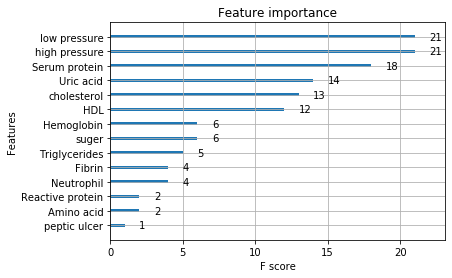

In [8]:
from xgboost import plot_importance

feature_name_list = ['peptic ulcer','high pressure','low pressure','suger','Uric acid','Triglycerides','cholesterol','HDL','LDL','Amino acid','Reactive protein','Serum protein','proteina','proteinb','Neutrophil','Fibrin','Hemoglobin']
dtrain = xgb.DMatrix(X, label=y, feature_names=feature_name_list)
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 9
model = xgb.train(param, dtrain)
plot_importance(model)

plt.show()